credits to the YOLO v4 repository that I use as the backbone of this.

In [1]:
import numpy as np
import pandas as pd
import rosbag
import os
import yaml
import random
import math as m
from scipy.spatial.distance import cdist
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


ganti yaml tiap awal generasi

In [2]:
#function for changing the parameter values (YAML file is used for the params to be called from the main UKF program)
def tes_yaml(P,Q):
    with open('/home/tartila/catkin_ws/src/golfi/config/ukf_ule_ga_params.yaml') as tes:             
        doc=yaml.safe_load(tes)
    if Q is not None:
        doc['process_noise_covariance_Q'] = Q
        doc['initial_estimate_covariance_P'] = P
   
    with open('/home/tartila/catkin_ws/src/golfi/config/ukf_ule_ga_params.yaml','w') as tes:      #save as
        yaml.safe_dump(doc, tes, indent=2, allow_unicode=False) #dah berhasil ni     

jalanin roslaunch berisi rosbag play, ukf dengan yaml baru untuk setiap generasi, dan rosbag record

In [3]:
#function for launching the 3 nodes: rosbag play back, the ukf algorithm, the recording of the rosbag to a temporary rosbag file that saves the estimation from the UKF
def launch():
    !roslaunch /home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch

jalanin rosbag import cari rmse

In [4]:
#function for loading the estimation values recorded in the temporary bag file
def ambil_bag():
    bag = rosbag.Bag('ga_temp.bag')
#     print(bag)
    states_xy=[]
    states_xy_baru=[]
    t = []

    for topic, msg, time in bag.read_messages(topics=['/ukf_states']):
        states_xy.append([msg.x,msg.y])
        t.append(msg.stamp.to_sec())
    
    states_xy = np.array(states_xy)
    t = np.array(t)
    
    states_xy = states_xy[np.all(states_xy != 0,axis = 1)] #buang yg 0
    states_xy = states_xy[np.all(~np.isnan(states_xy),axis = 1)] #buang yg nan
    t = t[t != 0]

    utm=[]
    utm_baru=[]
    t_utm = []

    for topic, msg, time in bag.read_messages(topics=['/utm']):
        utm.append([msg.pose.pose.position.x,msg.pose.pose.position.y])
        t_utm.append(time.to_sec())
        
    utm = np.array(utm)
    t_utm = np.array(t_utm)

    min = utm[0]

    i=0
    for a in states_xy:
        states_xy_baru.append([states_xy[i,0]-min[0],states_xy[i,1]-min[1]])
        i=i+1
    states_xy_baru=np.array(states_xy_baru)
    
    i=0
    for a in utm:
        utm_baru.append([utm[i,0]-min[0],utm[i,1]-min[1]])
        i=i+1
    utm_baru=np.array(utm_baru)
    return states_xy_baru, utm_baru, t, t_utm

def err2(est, gt, t_est, t_gt):
    j = 1
    sample_est = []
    sample_gt = []
    for i in range(1, len(t_gt)):
        while (t_gt[i] > t_est[j]):
            j += 1
            
        sample_est.append(est[j])
        sample_gt.append(gt[i])
    rmsee=sqrt(mse(sample_gt, sample_est))
    maee=mean_absolute_error(sample_gt, sample_est)
    print("rmse: "+str(rmsee)+"\nmae: "+str(maee))
    return rmsee,maee


In [5]:
#function for fitness evaluation
def fitness(rmse_groundtruth):
    t=1
#     if rmse_titikutm<0.0605: #value is acquired from observation
#         t=0
    return t/rmse_groundtruth

In [6]:
#function for plotting the estimation and the (unextended) GNSS points 
def plot(estimasi,gnss):
    plt.figure(figsize=(10,10))
    matplotlib.style.use('default')

    plt.scatter(estimasi[:,0],estimasi[:,1],s=2.,color='k') #odometry/filtered_map
    plt.scatter(gnss[:,0],gnss[:,1],s=5.,marker="x",c='C3',alpha=1)
    plt.show()

GA

In [7]:
#function for saving the acquired parameter values to an external .txt file
def catat(ptemp,qtemp,errortemp,fitnesstemp,p_path,q_path,error_path,error_bygen_path,fitness_path):
    p='%14.4g' * len(ptemp) % tuple(ptemp)
    q='%14.4g' * len(qtemp) % tuple(qtemp)
    error=str(errortemp)
    fitness=str(fitnesstemp)
    
    with open(p_path, 'a') as h:  
        h.write(p + '\n')
    with open(q_path, 'a') as h: 
        h.write(q + '\n')
    with open(error_path, 'a') as h:  
        h.write(error + '\n')
    with open(error_bygen_path, 'a') as h:  
        h.write(error + '\n')
    with open(fitness_path, 'a') as h:  
        h.write(fitness + '\n')
        
    x_q=np.loadtxt(q_path, ndmin=2)  
    x_p=np.loadtxt(p_path, ndmin=2) 

    x_error=np.loadtxt(error_path, ndmin=2)
    x_error_bygen=np.loadtxt(error_bygen_path, ndmin=2)
    x_fitness=np.loadtxt(fitness_path, ndmin=2)
    x_fitness_f=x_fitness.flatten()
    
    np.savetxt(p_path, x_p[np.argsort(-x_fitness_f)], '%10.5g')
    np.savetxt(q_path, x_q[np.argsort(-x_fitness_f)], '%10.5g')
    np.savetxt(error_path, x_error[np.argsort(-x_fitness_f)], '%10.5g')
    np.savetxt(error_bygen_path, x_error_bygen, '%10.5g') #savenya berdasarkan error, loadnya berdasarkan fitness
    np.savetxt(fitness_path, x_fitness[np.argsort(-x_fitness_f)], '%10.5g')  #[np.argsortnya ini nambah dimensi]

In [8]:

for a in range (0,31,6):
    print(a)

0
6
12
18
24
30


----------------------------------------------------------------------------------------------------
Generasi ke-1 dari 1000
... logging to /home/tartila/.ros/log/aca6f14c-5572-11eb-afed-74c63b0b1efd/roslaunch-tartila-G551VW-16548.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:35223/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 0.001
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [9.898, 0, 0, 0, ...
 * /kappa: -2
 * /process_noise_covariance_Q: [0.07537, 0, 0, 0...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_enc_GA (golfi/ukf_localization_2d_enc_GA)
    utm (gps_common/utm_odomet

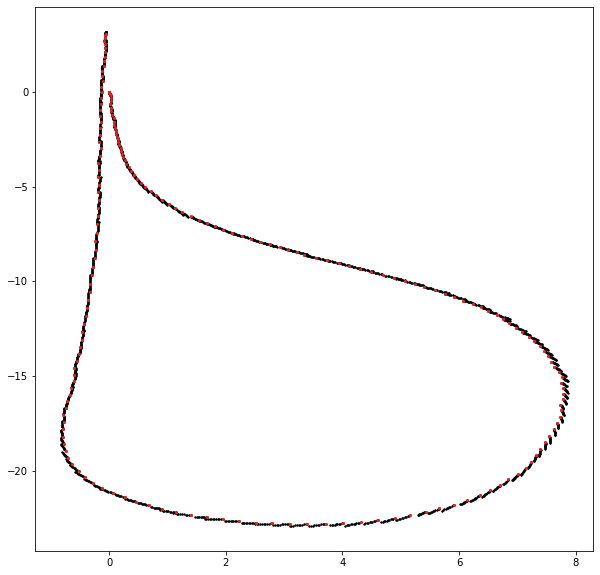

----------------------------------------------------------------------------------------------------
Generasi ke-2 dari 1000


ValueError: operands could not be broadcast together with shapes (1,25) (36,) 

In [9]:
#initializing the parameter values
p_temp=[9.898, 0, 0, 0, 0, 0, 6.56, 0, 0, 0, 0, 0, 8.528, 0,
  0, 0, 0, 0, 10.18, 0, 0, 0, 0, 0, 4.059] #hasil tune ga_yaw_dydx_2
q_temp=[0.07537, 0, 0, 0, 0, 0, 0.2025, 0, 0, 0, 0, 0, 18.58, 0,
  0, 0, 0, 0, 21.44, 0, 0, 0, 0, 0, 1.662]
 #hasil tune ga_yaw_dydx2

generasi=1000 #define the max number of generations

#defining the path for the parameter values to be saved to
p_path = "/home/tartila/catkin_ws/src/golfi/GA/p_path.txt"
q_path = "/home/tartila/catkin_ws/src/golfi/GA/q_path.txt"
fitness_path = "/home/tartila/catkin_ws/src/golfi/GA/fitness_path.txt"
error_path = "/home/tartila/catkin_ws/src/golfi/GA/error_path_byfitness.txt"
error_bygen_path = "/home/tartila/catkin_ws/src/golfi/GA/error_bygen.txt"

daftar_parameter=[]
npr=np.random

p_ortu=[]
q_ortu=[]
for i in range(generasi):
    print("----------------------------------------------------------------------------------------------------")
    print("Generasi ke-"+ str(i+1) + " dari " + str(generasi))

    if os.path.exists(p_path):
        p = np.loadtxt(p_path, ndmin=2)
        q = np.loadtxt(q_path, ndmin=2)
        error = np.loadtxt(error_path, ndmin=2)
        fitness = np.loadtxt(fitness_path, ndmin=2)

        #selection
        n = min(36, len(p)) #defining the number of the individuals in the mating pool
        fitness_f=fitness.flatten()
        
        p=p[np.argsort(-fitness_f)][:n] #load dari txt
        q=q[np.argsort(-fitness_f)][:n]
        error=error[np.argsort(-fitness_f)][:n]
        fitness=fitness[np.argsort(-fitness_f)][:n]
        batas_bawah=1e-03
        daftar_parameter=[p[0],q[0]] #saving the parameters in p and q as an array
        
        #crossover (recombination of values)
        if i>1: #picking the parents for the crossover
            indeks_ortu1,indeks_ortu2=random.sample(range(0, n), 2)
            p_ortu=p[[indeks_ortu1,indeks_ortu2],:]
            q_ortu=q[[indeks_ortu1,indeks_ortu2],:]
#             error_ortu=error[[indeks_ortu1,indeks_ortu2],:]
            fitness_ortu=fitness[[indeks_ortu1,indeks_ortu2],:]
            
            w1=fitness_ortu[0]/(fitness_ortu[0]+fitness_ortu[1])
            p=np.ones(36)
            q=np.ones(36)

            for j in range(36):
                pilih_ortu=npr.random()
                p[j]=(pilih_ortu<=w1)*p_ortu[0,j]+(pilih_ortu>w1)*p_ortu[1,j]

            for j in range(36):
                pilih_ortu=npr.random()
                q[j]=(pilih_ortu<=w1)*q_ortu[0,j]+(pilih_ortu>w1)*q_ortu[1,j]

        #mutation
        mp,s=0.8,6 #mutation probability and the multiplying factor defined
        if i<36: #the initial population number defined here
            mp,s=1,10 #for initial population, mutation is used to randomly pick the values around the inital values defines before
        penjumlah=[]
        apakah_mutasi=npr.random()
        if apakah_mutasi<mp:
            for a in range(12):
                penjumlah.append((npr.normal(0,1))) 
        else:
            penjumlah=np.zeros(12) #no addition for mutation
        
        m_p=np.zeros(36)
        m_q=np.zeros(36)
        i=0
        for b in range(0,36,7):
            m_p[b]=penjumlah[i]
            i+=1

            m_q[b]=penjumlah[i]
            i+=1
            
        p_temp = (p+m_p).flatten().tolist()
        q_temp = (q+m_q).flatten().tolist()
        print(np.matrix(p_temp))
        for b in range(0,36,7):
            if p_temp[b]<batas_bawah:
                p_temp[b]=batas_bawah
                
        print(np.matrix(q_temp))
        for c in range(0,36,7): #dibuat supaya q yaw tidak berubah
            if q_temp[c]<batas_bawah:
                q_temp[c]=batas_bawah

            
    #change the value of the parameter with the ones just acquired
    tes_yaml(p_temp,q_temp)
    #run the launch function
    launch()
    
    #acquiring the fitness value by taking the estimation value from the temporary bag file (ga_temp.bag) and running the fitness evaluation function
    hasil_ukf, utm, t_state, t_utm = ambil_bag()
    
    er_rmse,er_mae=err2(hasil_ukf, utm, t_state, t_utm)
    
#     ers = rmse(hasil_ukf, utm, t_state, t_utm)
#     fit = fitness(errorr)
    fit = 1/er_rmse
    
    #plot the estimation for every set of parameter values acquired
    plot(hasil_ukf,utm)
    
    #saving the parameter values acquired
    catat(p_temp,q_temp,er_rmse,fit,p_path,q_path,error_path,error_bygen_path,fitness_path)

In [11]:
hasil_ukf, utm, t_state, t_utm = ambil_bag()
    
errorr=err2(hasil_ukf, utm, t_state, t_utm)

0.0812216386148


In [13]:
fit = 1/errorr

In [14]:
fit

12.311989970337988